#### The need for data-independent $\phi(x)$

One of the annoying things we have encountered so far is that the virtual samples $\phi(x)$ we obtained via eigendecomposition for Bayesian kernel regression is `data-dependent`

That is, the virtual samples we get can only approximate the covariance structure over the data points that are used to generate these virtual samples, which can lead to some problems

* As shown previously, we have to `correct` the prediction `variance` in the end, as the covariance structure among testing data points is involved in the computation of prediction variance and our virtual samples cannot properly account for it
* Of course, if we could generate virtual samples from the kernel matrix over the entire input space (all training and testing points), then the covariance structure among all data points would be properly accounted for. However, this is very inefficient computationally, even if it is not infeasible

To take our approach based on weight-space view a bit further, we would like to make virtual samples `data-independent`

That is, we want to find a `computationally useful` mapping (as we have shown that the true one is infinite-dimensional) $\phi(x)$ that we can directly compute for each input $x$, and for every pair of $x_1, x_2$, the mapping preserves the correlation (as defined by `RBF kernel function` for our case)

$$\phi(x_1)^T\phi(x_2)=e^{-\frac{\|x_1-x_2\|^2}{2\sigma^2}}$$

#### Random features

Two great resources
* https://random-walks.org/book/papers/rff/rff.html
* https://gregorygundersen.com/blog/2019/12/23/random-fourier-features/

Let $\omega$ be a random $d$-dimensional vector from standard Gaussian distribution $\omega \sim N(0, I)$ and let $e(x)=\exp(i\omega^Tx)$

Let $\delta = x_1-x_2$, we write out the following expectation

$$\begin{align*}
\mathbb{E}_{\omega}[e(x_1)e(x_2)^*] & = \mathbb{E}_{\omega}[\exp(i\omega^Tx_1)\exp(-i\omega^Tx_2)] \\
&=\mathbb{E}_{\omega}[\exp(i\omega^T(x_1-x_2)] \\
&=\int_{R^d}p(\omega)\exp(i\omega^T(x_1-x_2)) d\omega \\
&=\int_{R^d}p(\omega)\exp(i\omega^T\delta) d\omega \\
& \text{plug in standard Gaussian expression } p(\omega)\\
&=(2\pi)^{-d/2}\int_{R^d}\exp(-\frac{1}{2}\omega^T\omega)\exp(i\omega^T\delta) d\omega \\
&=(2\pi)^{-d/2}\int_{R^d}\exp\left(-\frac{1}{2}\omega^T\omega+i\omega^T\delta\right)
d\omega \\
&=(2\pi)^{-d/2}\int_{R^d}\exp\left(-\frac{1}{2}\left(\omega^T\omega-2i\omega^T\delta-\delta^T\delta\right)-\frac{1}{2}\delta^T\delta\right)
d\omega \\
&=(2\pi)^{-d/2}\exp\left(-\frac{1}{2}\delta^T\delta\right)\int_{R^d}\exp\left(-\frac{1}{2}\left(\omega^T\omega-2i\omega^T\delta-\delta^T\delta\right)\right)
d\omega \\
&=(2\pi)^{-d/2}\exp\left(-\frac{1}{2}\delta^T\delta\right)\int_{R^d}\exp\left(-\frac{1}{2}(\omega-i\delta)^T(\omega-i\delta)\right)
d\omega \\
& \text{the integral is unnormalized Gaussian} \\
&=(2\pi)^{-d/2} \exp\left(-\frac{1}{2}\delta^T\delta\right) (2\pi)^{d/2} \\
&=\exp\left(-\frac{1}{2}\delta^T\delta\right) \\
&=\exp\left(-\frac{1}{2}\|x_1-x_2\|^2\right)
\end{align*}$$

We see that this is the RBF kernel we want!

Now, we need to have this approximated by `dot product` of a mapping

We know that we can approximate the integral above

$$\int_{R^d}p(\omega)\exp(i\omega^T(x_1-x_2)) d\omega$$

using `Monte Carlo` method

$$\begin{align*}
\mathbb{E}_{\omega}[e(x_1)e(x_2)^*] & = \mathbb{E}_{\omega}[\exp(i\omega^Tx_1)\exp(-i\omega^Tx_2)] \\
&=\mathbb{E}_{\omega}[\exp(i\omega^T(x_1-x_2)] \\
&=\int_{R^d}p(\omega)\exp(i\omega^T(x_1-x_2)) d\omega \\
& \approx \frac{1}{m}\sum_{j=1}^m \exp(i\omega_j^T(x_1-x_2)) \\
&=\frac{1}{\sqrt{m}}\begin{bmatrix}\exp(i\omega_1^Tx_1)\\\exp(i\omega_2^Tx_1)\\ \vdots \\ \exp(i\omega_m^Tx_1)\end{bmatrix}^T\frac{1}{\sqrt{m}}\begin{bmatrix}\exp(-i\omega_1^Tx_2)\\\exp(-i\omega_2^Tx_2)\\ \vdots \\ \exp(-i\omega_m^Tx_2)\end{bmatrix}
\end{align*}$$

We are getting close as the final expression is now in dot product of two vectors, but we still need to get rid of the imaginary part

Note that both $\omega$ and our kernel function results are `real`, therefore, we have (with Euler's formula)

$$\boxed{\exp(i\omega^T(x_1-x_2))=\cos(\omega^T(x_1-x_2))}$$

If we define $z(x)=\sqrt{2} \cos(\omega^Tx+b), \, b\sim \text{Uniform}(0, 2\pi)$

and with the following

$$\begin{align*}
\cos(x+y) + \cos(x-y) &= \cos(x+y)+\cos(x+(-y))\\
&= (\cos x \cos y- \sin x \sin y)+(\cos x \cos (-y) -\sin x \sin (-y)) \\
&=2 \cos x \cos y
\end{align*}$$

we can show that

$$\begin{align*}
\mathbb{E}_{\omega}[z(x_1)z(x_2)] & = \mathbb{E}_{\omega}[\sqrt{2} \cos(\omega^Tx_1+b)\sqrt{2} \cos(\omega^Tx_2+b)] \\
& = \mathbb{E}_{\omega,b}[\cos(\omega^T(x_1+x_2)+2b)] + \mathbb{E}_{\omega}[\cos(\omega^T(x_1-x_2))] \\
& \text{law of total expectation} \\
&=\mathbb{E}_{\omega}[\mathbb{E}_{b}[\cos(\omega^T(x_1+x_2)+2b)|\omega]]+ \mathbb{E}_{\omega}[\cos(\omega^T(x_1-x_2))] \\
&=\mathbb{E}_{\omega}[\frac{1}{2\pi}\int_0^{2\pi} \cos(\omega^T(x_1+x_2)+2b) \,db]+ \mathbb{E}_{\omega}[\cos(\omega^T(x_1-x_2))] \\
& \text{integral in first term is zero due to periodicity of cosine} \\
&=\boxed{\mathbb{E}_{\omega}[\cos(\omega^T(x_1-x_2))]}
\end{align*}$$

#### Random Fourier features (RFFs)

Now we can define our $\phi(x)$ as

$$\begin{align*}
\phi(x) &=\frac{1}{\sqrt{m}}\begin{bmatrix}z(x; \omega_1, b_1) \\ \vdots \\z(x; \omega_m, b_m) \end{bmatrix}\\
&= \begin{bmatrix}\sqrt{\frac{2}{m}}\cos(\omega_1^Tx+b_1) \\ \vdots \\\sqrt{\frac{2}{m}}\cos(\omega_m^Tx+b_m)\end{bmatrix}
\end{align*}$$

We can show that

$$\begin{align*}
\phi(x_1)^T\phi(x_2)&=\begin{bmatrix}\sqrt{\frac{2}{m}}\cos(\omega_1^Tx_1+b_1) &\cdots &\sqrt{\frac{2}{m}}\cos(\omega_m^Tx_1+b_m)\end{bmatrix}\begin{bmatrix}\sqrt{\frac{2}{m}}\cos(\omega_1^Tx_2+b_1) \\ \vdots \\\sqrt{\frac{2}{m}}\cos(\omega_m^Tx_2+b_m)\end{bmatrix} \\
&= \frac{1}{m}\sum_{i=1}^m\left[\sqrt{2}\cos(\omega_i^Tx_1+b_i)\right]\left[\sqrt{2}\cos(\omega_i^Tx_2+b_i)\right] \\
&\approx \mathbb{E}_{\omega}[\cos(\omega^T(x_1-x_2))]\\
&=\exp\left(-\frac{1}{2}\|x_1-x_2\|^2\right)
\end{align*}$$


where

* $\omega_i$ follows `Gaussian distribution` $N(0, I)$ (vector or scalar, scale covariance by $\frac{1}{\sigma_k}$ if $\sigma_k\neq 1$)
* $b_i$ follows `uniform distribution` over $(0, 2\pi)$ (scalar)
* $m$ is a parameter indicating the number of RFFs to construct $\phi(\cdot)$

#### Matrix notation

If we have $n$ data points $x_1, \cdots, x_n\in\mathbf{R}^d$, then their RFFs can be expressed compactly as

$$\begin{align*}
\begin{bmatrix}\phi(x_1)^T \\ \vdots \\ \phi(x_n)^T\end{bmatrix}
&= \begin{bmatrix}\begin{bmatrix}\sqrt{\frac{2}{m}}\cos(\omega_{1}^Tx_1+b_1) &\cdots &\sqrt{\frac{2}{m}}\cos(\omega_{m}^Tx_1+b_m)\end{bmatrix} \\ \vdots \\ \begin{bmatrix}\sqrt{\frac{2}{m}}\cos(\omega_{1}^Tx_n+b_1) &\cdots &\sqrt{\frac{2}{m}}\cos(\omega_{m}^Tx_n+b_m)\end{bmatrix}\end{bmatrix} \\
&=\sqrt{\frac{2}{m}}\cos \left(\begin{bmatrix}\begin{bmatrix}(\omega_{1}^Tx_1+b_1) &\cdots &(\omega_{m}^Tx_1+b_m)\end{bmatrix} \\ \vdots \\ \begin{bmatrix}(\omega_{1}^Tx_n+b_1) &\cdots &(\omega_{m}^Tx_n+b_m)\end{bmatrix}\end{bmatrix}\right)\\
&=\sqrt{\frac{2}{m}}\cos  \left(\begin{bmatrix}x_1^T \\ \vdots \\x_n^T\end{bmatrix}_{n \times d}\begin{bmatrix}\omega_1 & \cdots &\omega_m\end{bmatrix}_{d \times m}+\begin{bmatrix}b_1 & \cdots &b_m \end{bmatrix}_{1 \times m}\right)
\end{align*}$$

where the final line uses `broadcasting`

#### We can compare true RBF kernel function and approximation using RFFs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
plt.style.use('dark_background')

In [ ]:
def rbf_rff_comparison(d=1, m=150, n=100, sigma=1.):
    x = np.linspace(0, 6, n) # n: number of data
    omega = np.random.normal(0, 1/sigma, (d, m)) # d: data dim, m: number of RFFs
    b = np.random.uniform(0, 2*np.pi, (1, m))

    # RFFs
    phi = np.sqrt(2/m) * np.cos(x.reshape(-1, 1) @ omega + b)
    print(phi.shape)

    # Anchor point
    x_1 = x[n // 2]

    # Compute RBF function centered at x_1
    rbf_function = np.exp(-0.5 * (x - x_1)**2 / sigma**2)
    print(rbf_function.shape)

    # Compute approximation based on RFFs
    rff_approximation = phi @ phi[n // 2].T
    print(rff_approximation.shape)

    # Plot both
    plt.figure(figsize=(8,4))
    plt.plot(x, rbf_function, 'm', linewidth=2, label='RBF function')
    plt.plot(x, rff_approximation, 'c', linewidth=2, label='RFF approximation')
    plt.legend()
    plt.show()

(200, 300)
(200,)
(200,)


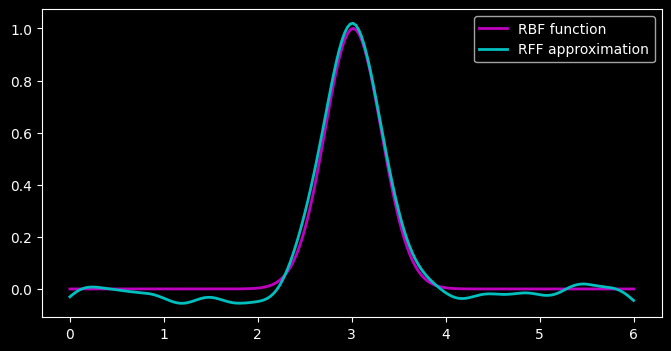

In [ ]:
np.random.seed(42)

rbf_rff_comparison(d=1, m=300, n=200, sigma=0.3)